# Regression Analysis

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb 
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

sns.set(context='notebook', style='whitegrid', font_scale=1.2)

## Data Import and Setup

In [2]:
sf = pd.read_csv('data_files/sf_clean.csv')

# Reformatting hood_district names
sf['hood_district'] = sf['hood_district'].astype(int)
sf['hood_district'] = sf['hood_district'].astype(str)

### Dropping Outliers (price > 10k)

In [3]:
sf = sf[sf['price'] < 8000]

In [4]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 976 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          976 non-null    int64  
 1   sqft           976 non-null    float64
 2   beds           976 non-null    float64
 3   bath           976 non-null    float64
 4   laundry        976 non-null    object 
 5   pets           976 non-null    object 
 6   housing_type   976 non-null    object 
 7   parking        976 non-null    object 
 8   hood_district  976 non-null    object 
dtypes: float64(3), int64(1), object(5)
memory usage: 76.2+ KB


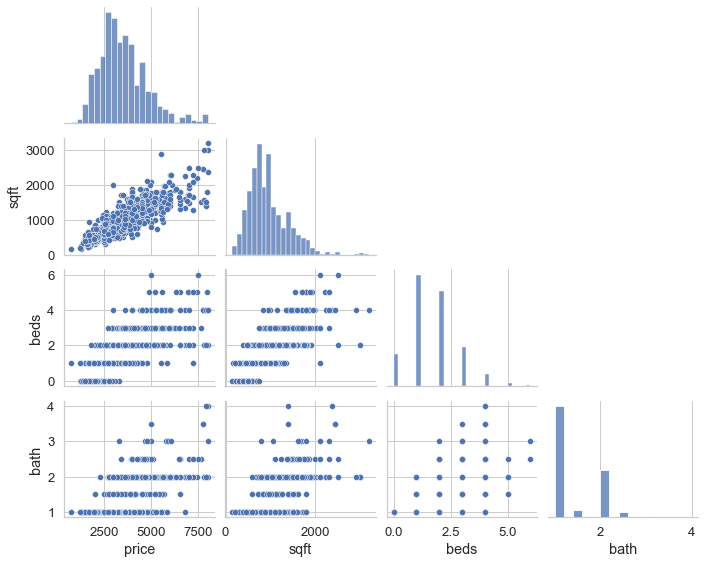

In [5]:
sns.pairplot(sf, height=2, aspect=1.25, corner=True);

### Dropping Features

In [6]:
#sf = sf.drop(['pets'], axis=1)
sf = sf.drop(['housing_type'], axis=1)

### Dummy variables

In [7]:
sf = pd.get_dummies(sf)

In [8]:
cols_to_drop = ['laundry_(c) no laundry',
               #'laundry_(b) on-site',
               'pets_(d) no pets', 
               #'housing_type_(c) multi', 
               'parking_(d) no parking',
               'hood_district_10']

sf = sf.drop(cols_to_drop, axis=1)

## Train/Test Splits

In [9]:
X, y = sf.drop('price',axis=1), sf['price']

# Training versus Test Data
# hold out 30% of the data for testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [10]:
# Scaling for Ridge & Lasso 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X.values)
X_test_scaled = scaler.transform(X_test.values)

## Linear

In [11]:
lin = LinearRegression()

lin.fit(X, y)
print(f'Linear Regression train R^2: {lin.score(X, y):.5f}')
print(f'Linear Regression val R^2: {lin.score(X_test, y_test):.5f}')

Linear Regression train R^2: 0.78529
Linear Regression val R^2: 0.82279


In [12]:
lin_predict = lin.predict(X_test)

lin_rmse = mean_squared_error(y_test, lin_predict, squared=False)
lin_rmse

539.0815636290351

## Lasso

In [13]:
alphavec = 10**np.linspace(-2,1,100)

lasso_model = LassoCV(alphas = alphavec, cv=3)
lasso_model.fit(X_train_scaled, y)

LassoCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,
        0.081...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ]),
        cv=3)

In [14]:
las_alpha = lasso_model.alpha_
las_alpha

0.4037017258596556

In [15]:
las = Lasso(alpha=las_alpha)

las.fit(X_train_scaled, y)
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y):.5f}')
print(f'Lasso Regression test R^2: {las.score(X_test_scaled, y_test):.5f}')

Lasso Regression train R^2: 0.78527
Lasso Regression test R^2: 0.82273


## Ridge

In [16]:
alphavec = 10**np.linspace(-2,1,100)

ridge_model = RidgeCV(alphas = alphavec, cv=3)
ridge_model.fit(X_train_scaled, y)

RidgeCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,
        0.081...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ]),
        cv=3)

In [17]:
rid_alpha = ridge_model.alpha_
rid_alpha

0.01

In [18]:
rid = Ridge(alpha=rid_alpha)

rid.fit(X_train_scaled, y)
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y):.5f}')
print(f'Ridge Regression test R^2: {rid.score(X_test_scaled, y_test):.5f}')

Ridge Regression train R^2: 0.78529
Ridge Regression test R^2: 0.82279


## Evaluation

### Linear

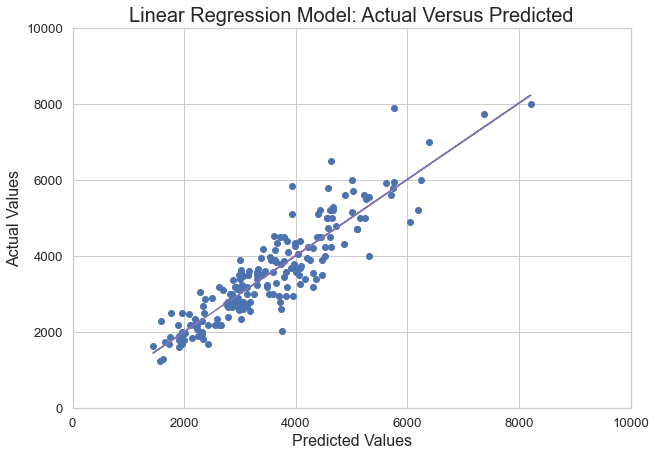

In [19]:
lin_predict = lin.predict(X_test)

plt.figure(figsize=(10, 7))
plt.scatter(lin_predict, y_test) 

z = np.polyfit(lin_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(lin_predict, p(lin_predict), 'm-')

plt.xlim(0, 10000)
plt.ylim(0, 10000)

plt.title('Linear Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

### Ridge

In [20]:
rid_predict = rid.predict(X_test_scaled)

mean_squared_error(y_test, rid_predict, squared=False)

539.0839424293782

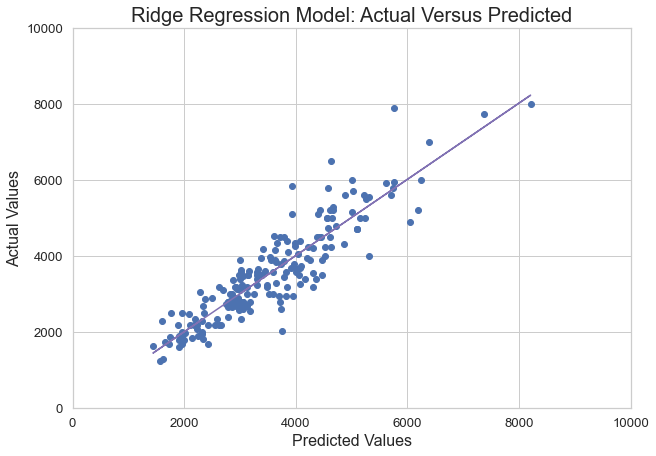

In [21]:
plt.figure(figsize=(10, 7))
plt.scatter(rid_predict, y_test) 

z = np.polyfit(rid_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(rid_predict, p(rid_predict), 'm-')

plt.xlim(0, 10000)
plt.ylim(0, 10000)

plt.title('Ridge Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

### Lasso

In [22]:
las_predict = las.predict(X_test_scaled)

mean_squared_error(y_test, las_predict, squared=False)

539.1751800010933

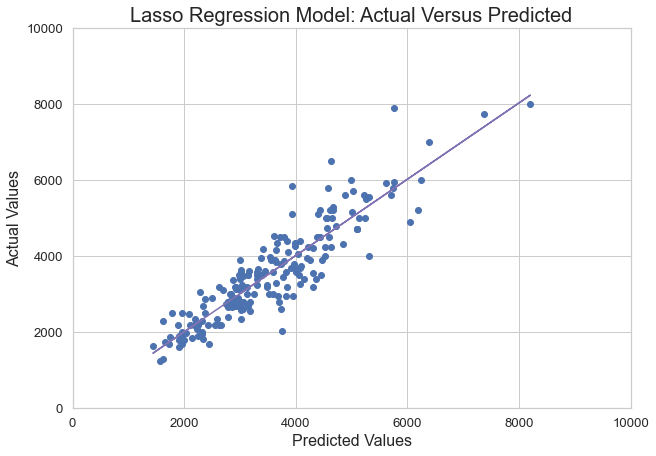

In [23]:
plt.figure(figsize=(10, 7))
plt.scatter(las_predict, y_test) 

z = np.polyfit(las_predict, y_test, 1)
p = np.poly1d(z)
plb.plot(las_predict, p(las_predict), 'm-')

plt.xlim(0, 10000)
plt.ylim(0, 10000)

plt.title('Lasso Regression Model: Actual Versus Predicted', fontsize=20)
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Actual Values', fontsize=16);

### Coefficients

In [24]:
lin_coefs = lin.coef_
rid_coefs = rid.coef_
las_coefs = las.coef_

features = sf.columns[1:]

coef_data = {'Features': features,
             'Linear': lin_coefs,
             'Ridge': rid_coefs,
             'Lasso': las_coefs}

coef_df = pd.DataFrame(coef_data)
coef_df

,Features,Linear,Ridge,Lasso
0,sqft,1.501839,646.337222,646.572637
1,beds,270.555503,285.453447,285.113258
2,bath,265.306416,139.746188,139.300470
3,laundry_(a) in-unit,322.268261,161.077341,159.453745
4,laundry_(b) on-site,20.641211,10.000400,8.413957
5,pets_(a) both,27.830117,13.405062,13.259636
6,pets_(b) dogs,172.312108,22.878495,22.650095
7,pets_(c) cats,10.238427,3.019980,2.549432
8,parking_(a) valet,681.789644,110.354833,110.043251
9,parking_(b) protected,132.895392,65.986752,65.893495


### OUTPUT 

In [25]:
# Linear
print(f'Linear Regression train R^2: {lin.score(X, y):.5f}')
print(f'Linear Regression val R^2: {lin.score(X_test, y_test):.5f}')
print(mean_squared_error(y_test, lin_predict, squared=False))
print("")

# Lasso
print(f'Lasso Regression train R^2: {las.score(X_train_scaled, y):.5f}')
print(f'Lasso Regression test R^2: {las.score(X_test_scaled, y_test):.5f}')
print(mean_squared_error(y_test, las_predict, squared=False))
print("")

# Ridge
print(f'Ridge Regression train R^2: {rid.score(X_train_scaled, y):.5f}')
print(f'Ridge Regression test R^2: {rid.score(X_test_scaled, y_test):.5f}')
print(mean_squared_error(y_test, rid_predict, squared=False))

Linear Regression train R^2: 0.78529
Linear Regression val R^2: 0.82279
539.0815636290351

Lasso Regression train R^2: 0.78527
Lasso Regression test R^2: 0.82273
539.1751800010933

Ridge Regression train R^2: 0.78529
Ridge Regression test R^2: 0.82279
539.0839424293782
